In [1]:
import mne
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA
import toml
import mne_bids
import re
from pathlib import Path
import matplotlib
import numpy as np
from ipywidgets import interact

mne.viz.set_browser_backend("matplotlib")
mne.set_config('MNE_BROWSER_THEME', 'light')
# matplotlib.use("Agg")


config = toml.load("../../.env.toml")
project_path = config["project"]["path"]

Using matplotlib as 2D backend.


This file contains preprocessing files after downsampling them.


In [2]:
subject = "114"
print(f"Processing subject {subject}")

fname_path = f"{project_path}/data/raw/BIDS/sub-{subject}/ses-01/eeg/sub-{subject}_ses-01_task-rest_eeg.set"
figure_path = f"{project_path}/reports/figures/sub-{subject}"
specparam_path = f"{project_path}/data/preprocessed/specparam/sub-{subject}"
clean_epochs_path = f"{project_path}/data/preprocessed/clean-epochs/sub-{subject}"


Path(figure_path).mkdir(parents=True, exist_ok=True)
Path(specparam_path).mkdir(parents=True, exist_ok=True)
Path(clean_epochs_path).mkdir(parents=True, exist_ok=True)


## This part could be replaced by read MFF files (set files are just downsampled MFF files saved to the local laptop drive)

raw = mne.io.read_raw_eeglab(fname_path, preload=True)

# raw = mne.io.read_raw_egi(fname_path, preload=True)
ch_name_type = dict(zip(raw.ch_names, raw.get_channel_types()))

ch_name_ecg = [name for name in raw.ch_names if name in "ECG"]
dict_ecg = {sub[0]: "ecg" for sub in (ele.split() for ele in ch_name_ecg)}

raw.set_channel_types(dict_ecg)
montage = mne.channels.make_standard_montage("GSN-HydroCel-257")
raw.set_montage(montage, match_alias={"VREF": "Cz"})
# VREF is dropped
#raw.drop_channels("VREF")
#raw.rename_channels({'VREF': 'Cz'})
raw.info['bads'] = ['VREF']
raw_downsampled = (
    raw.copy().crop(tmin=5, tmax=300, include_tmax=True)
)

Processing subject 114


Instead of applying a high pass filter that can remove a spurious correlation to remove the baseline fluctuations I am using robust detrending using polynomials that ignore outliers [@decheveigne2018RobustDetrendingRereferencing]
Detrending is done twice - first using a line and then a higher-order polynomial to remove faster baseline fluctuations.


In [3]:
# detrending
from meegkit.detrend import detrend

raw_detrended = raw_downsampled.copy()
X = raw_detrended.get_data().T  # transpose so the data is organized time-by-channels
X, _, _ = detrend(X, order=1)
X, _, _ = detrend(X, order=6)
raw_detrended._data = X.T  # overwrite raw data


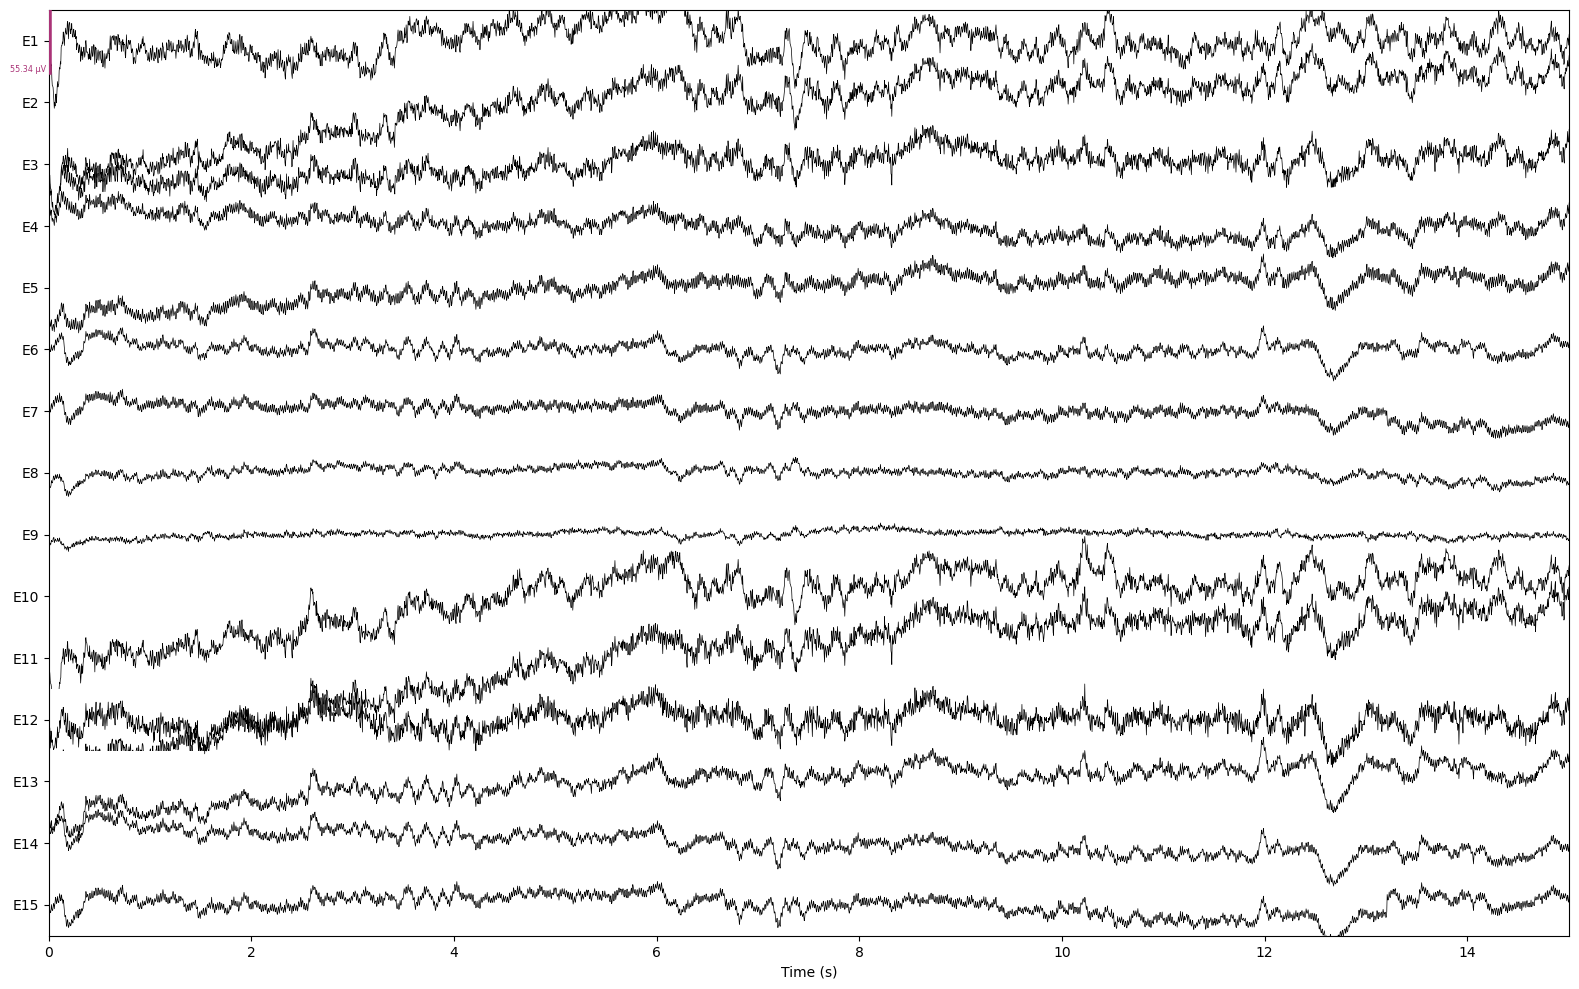

Effective window size : 8.192 (s)


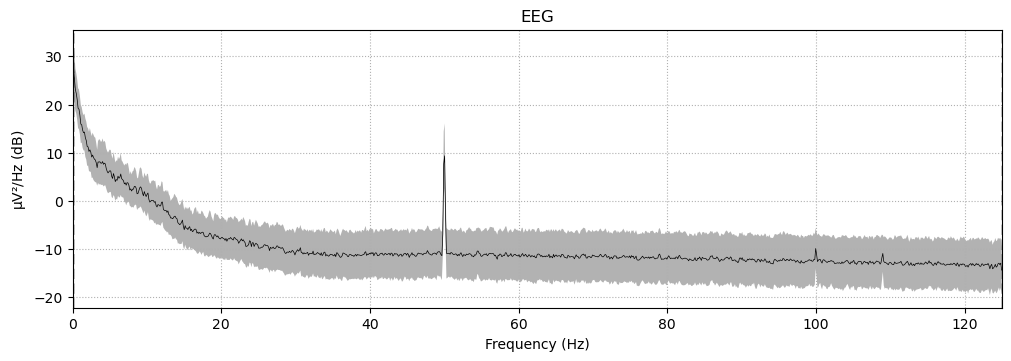

In [4]:
raw_detrended_plot = mne.viz.plot_raw(raw_detrended, duration=15.0, scalings="auto",  n_channels=15, show_scrollbars= False)
raw_detrended_plot.savefig(f'{figure_path}/sub-{subject}_raw_detrended.png', dpi=300, bbox_inches='tight')
# Plot is saved to monitor the quality of the data

raw_detrended_psd = raw_detrended.compute_psd(method="welch", picks="eeg", exclude="bads").plot(
    average=True, picks="eeg", exclude="bads", show=False
)
raw_detrended_psd.savefig(f'{figure_path}/sub-{subject}_raw-detrended-psd.png', dpi=300, bbox_inches='tight')


# Identifying bad channels


In [5]:
from pyprep.find_noisy_channels import NoisyChannels
nd = NoisyChannels(raw_detrended, random_state=1337)
#nd.find_bad_by_correlation(correlation_secs=1.0, correlation_threshold=0.4, frac_bad=0.01)
#nd.find_bad_by_deviation(deviation_threshold=5.0)
#nd.find_all_bads(ransac=False, channel_wise=True, max_chunk_size=None)
nd.find_bad_by_ransac(channel_wise=True) #find bad by RANSAC is conservative estimate
print(nd.bad_by_ransac)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.7s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 86
Total # of chunks: 3
Current chunk:
1
2
3

RANSAC done!
['E145', 'E146', 'E186']


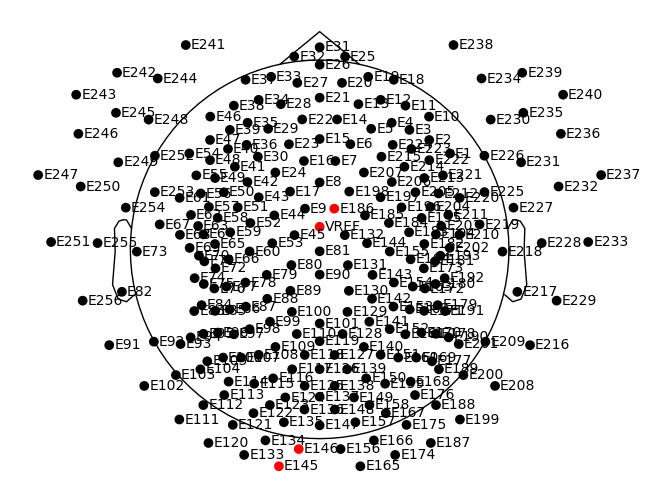

In [6]:
raw_detrended.info['bads'].extend(nd.bad_by_ransac)
sensor_plot = raw_detrended.plot_sensors(show_names=True)
sensor_plot.savefig(f'{figure_path}/sub-{subject}_bad_sensors.png', dpi=300, bbox_inches='tight')

# Prepare data for ICA projection


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method


- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-12 dB cutoff frequency: 47.50 Hz)
- Filter length: 1650 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.1s


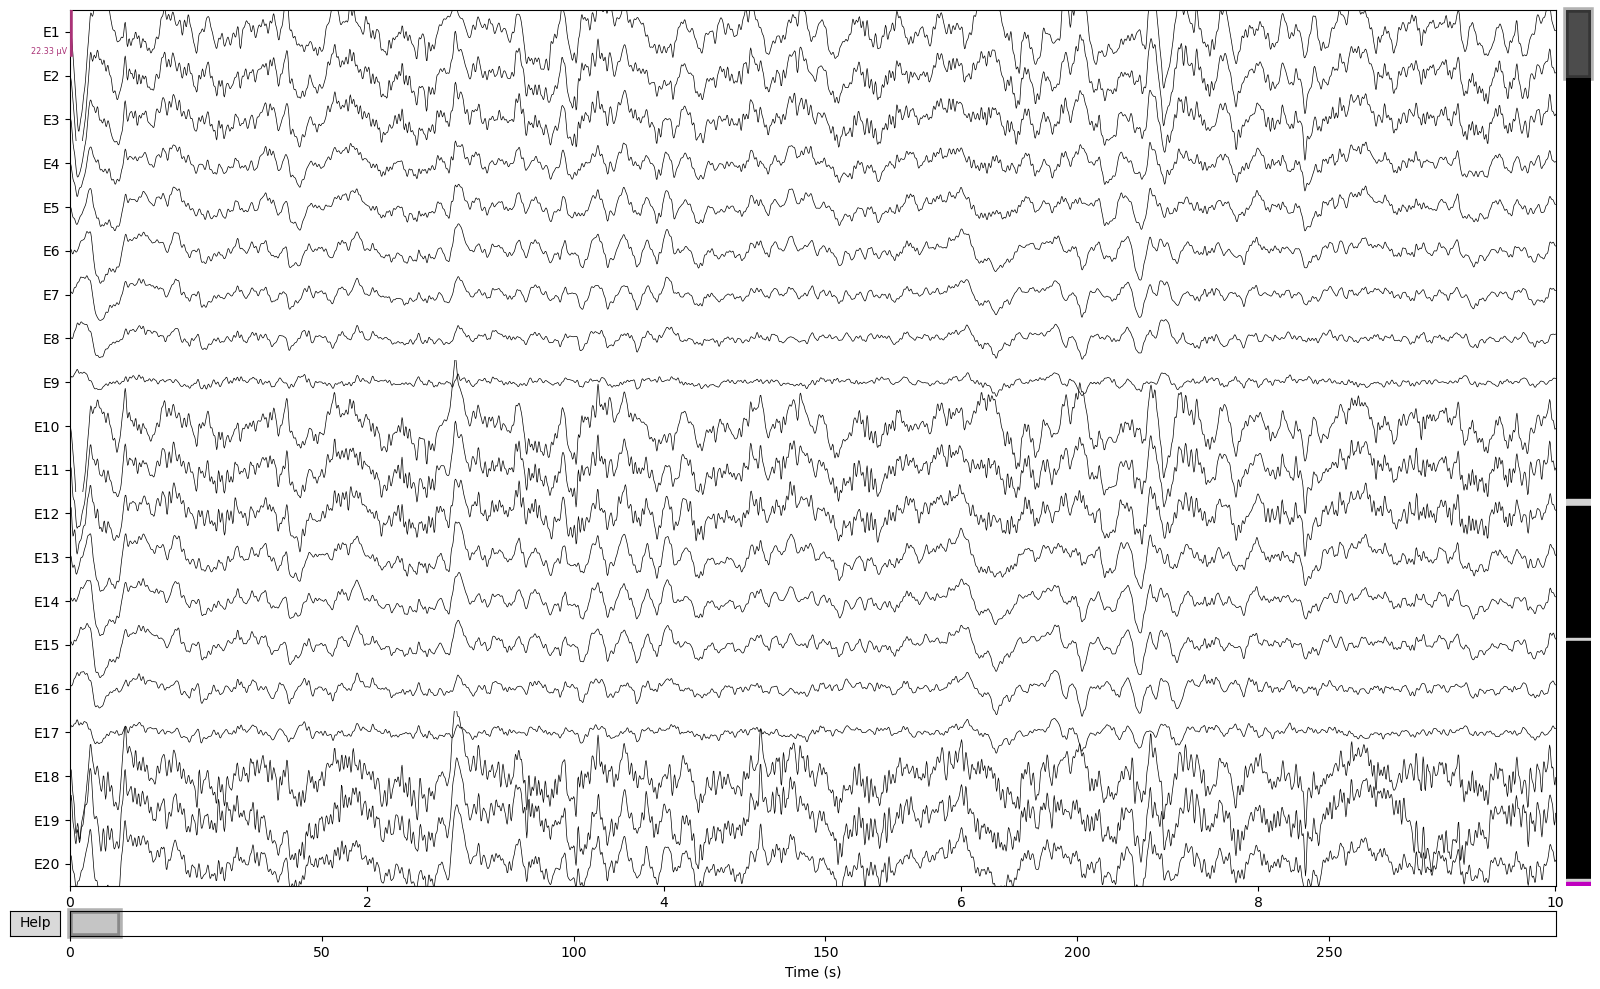

In [7]:
filter_params = {
    "l_freq": 1,
    "h_freq": 45,
    "h_trans_bandwidth": 5,
    "fir_design": "firwin2",
    "phase": "zero-double",
}
raw_filtered = raw_detrended.filter(**filter_params)  # removedrifts


# raw_clean = raw_filtered.copy()
# raw_clean.info['bads'].extend(nd.bad_by_ransac)
# raw_clean.interpolate_bads()
# raw_clean.set_eeg_reference('average', projection=True)  #compute the reference
# raw_filtered.add_proj(raw_clean.info['projs'][0])
# del raw_clean  # delete the copy
# raw_filtered.apply_proj()  # apply the reference

# # I want to know which chanels are interpolated
# raw_filtered.info['bads'].extend(nd.bad_by_ransac)
# raw_detrended_interp = raw_detrended.interpolate_bads(reset_bads=True)

raw_filtered_plot = mne.viz.plot_raw(raw_filtered, duration=10.0,  n_channels=20,   scalings="auto")
raw_filtered_plot.savefig(f'{figure_path}/sub-{subject}_raw_filtered.png', dpi=300, bbox_inches='tight')

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 1001 original time points ...


2 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


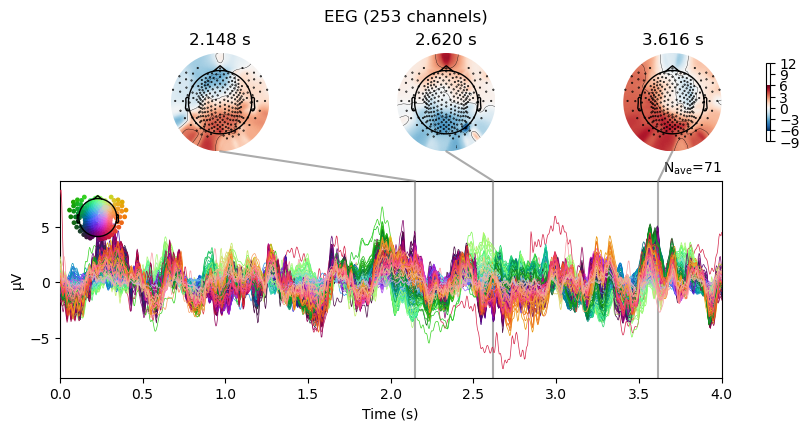

Effective window size : 4.004 (s)
Averaging across epochs...


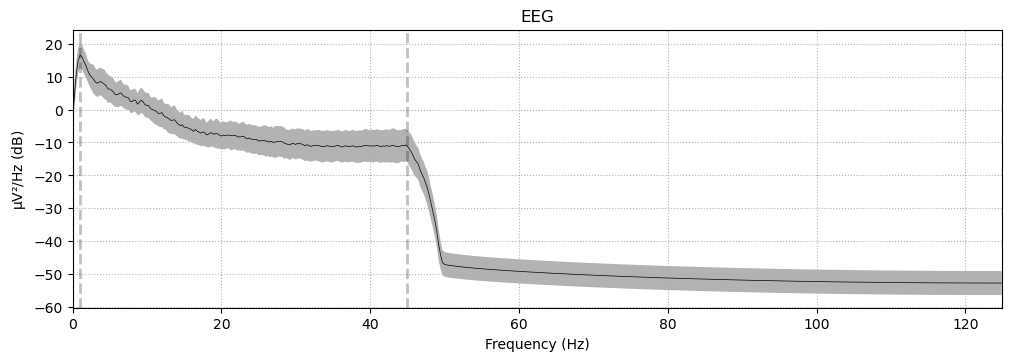

In [8]:
events = mne.make_fixed_length_events(
    raw=raw_filtered, start=0, stop=None, duration=4, overlap=0, first_samp=False
)

# Create  Epochs object
epochs = mne.Epochs(
    raw=raw_filtered,
    events=events,
    tmin=0,
    tmax=4,
    detrend=0,
    baseline=None,
    preload=True,
)
# plot the data
epochs_plot = epochs.copy().average().detrend().plot_joint()
epochs_plot.savefig(f'{figure_path}/sub-{subject}_epochs_plot.png', dpi=300, bbox_inches='tight')

epochs_plot_psd = epochs.compute_psd(method="welch", picks="eeg", exclude="bads").plot(
    average=True, picks="eeg", exclude="bads", show=False
)
epochs_plot_psd.savefig(f'{figure_path}/sub-{subject}_epochs_plot_psd.png', dpi=300, bbox_inches='tight')

# Removing the noise from the data


In [9]:
ar = autoreject.AutoReject(
    n_interpolate=[1, 2, 4, 8, 16, 32, 64, 128], random_state=11, n_jobs=1, verbose=True
)
ar.fit(epochs[:20])  # fit on a few epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/autoreject/utils.py:73: UserWarning: 4 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Creating augmented epochs : 0/253 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/253 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/8 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=32


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/autoreject/utils.py:73: UserWarning: 4 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Repairing epochs : 0/71 [00:00<?,       ?it/s]

Dropped 3 epochs: 27, 63, 70


No projector specified for this dataset. Please consider the method self.add_proj.


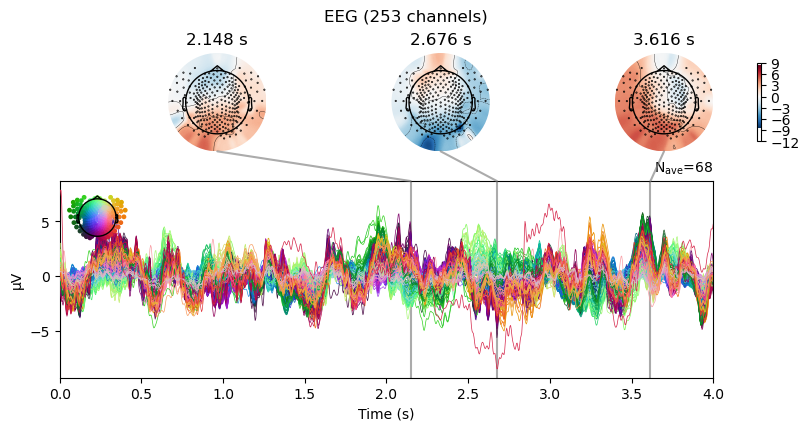

Effective window size : 4.004 (s)
Averaging across epochs...


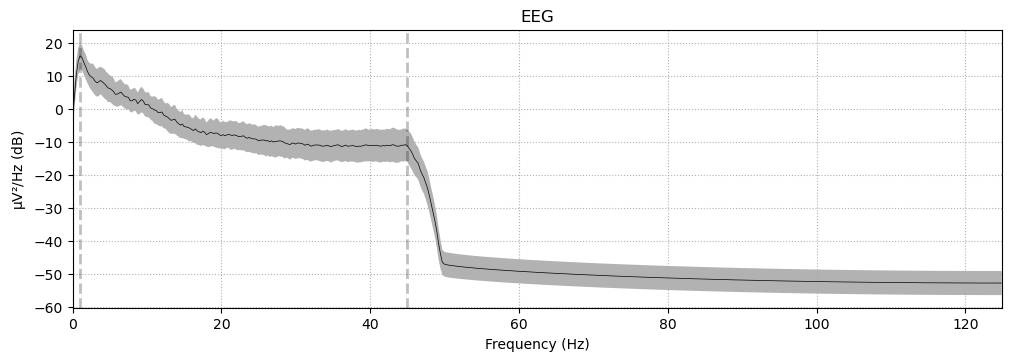

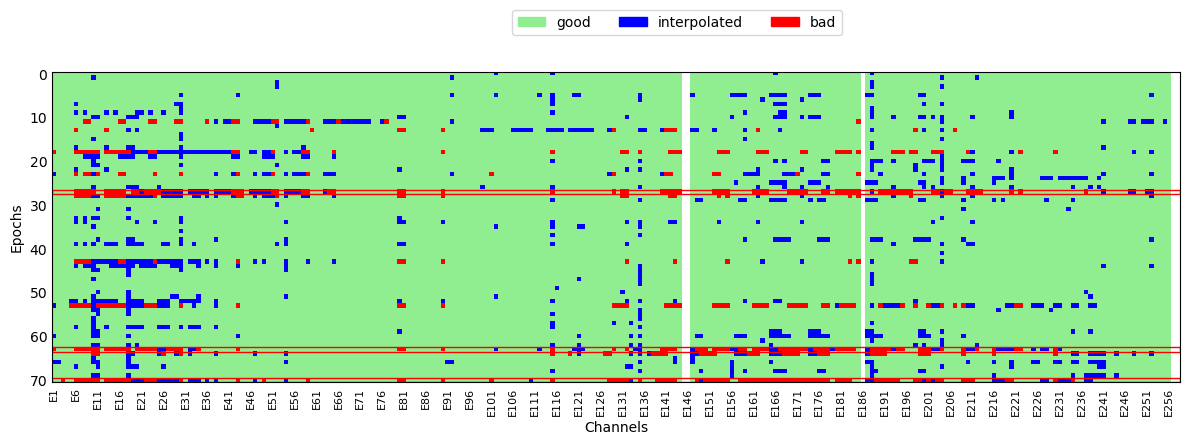

In [10]:
epoch_ar_plot = epochs[~reject_log.bad_epochs].copy().average().detrend().plot_joint()
epochs_ar_psd = epochs[~reject_log.bad_epochs].compute_psd(method="welch", picks="eeg", exclude="bads").plot(
    average=True, picks="eeg", exclude="bads", show=False
)
reject_plot = reject_log.plot(orientation="vertical")
reject_plot.savefig(f'{figure_path}/sub-{subject}_reject_log.png', dpi=300, bbox_inches='tight')

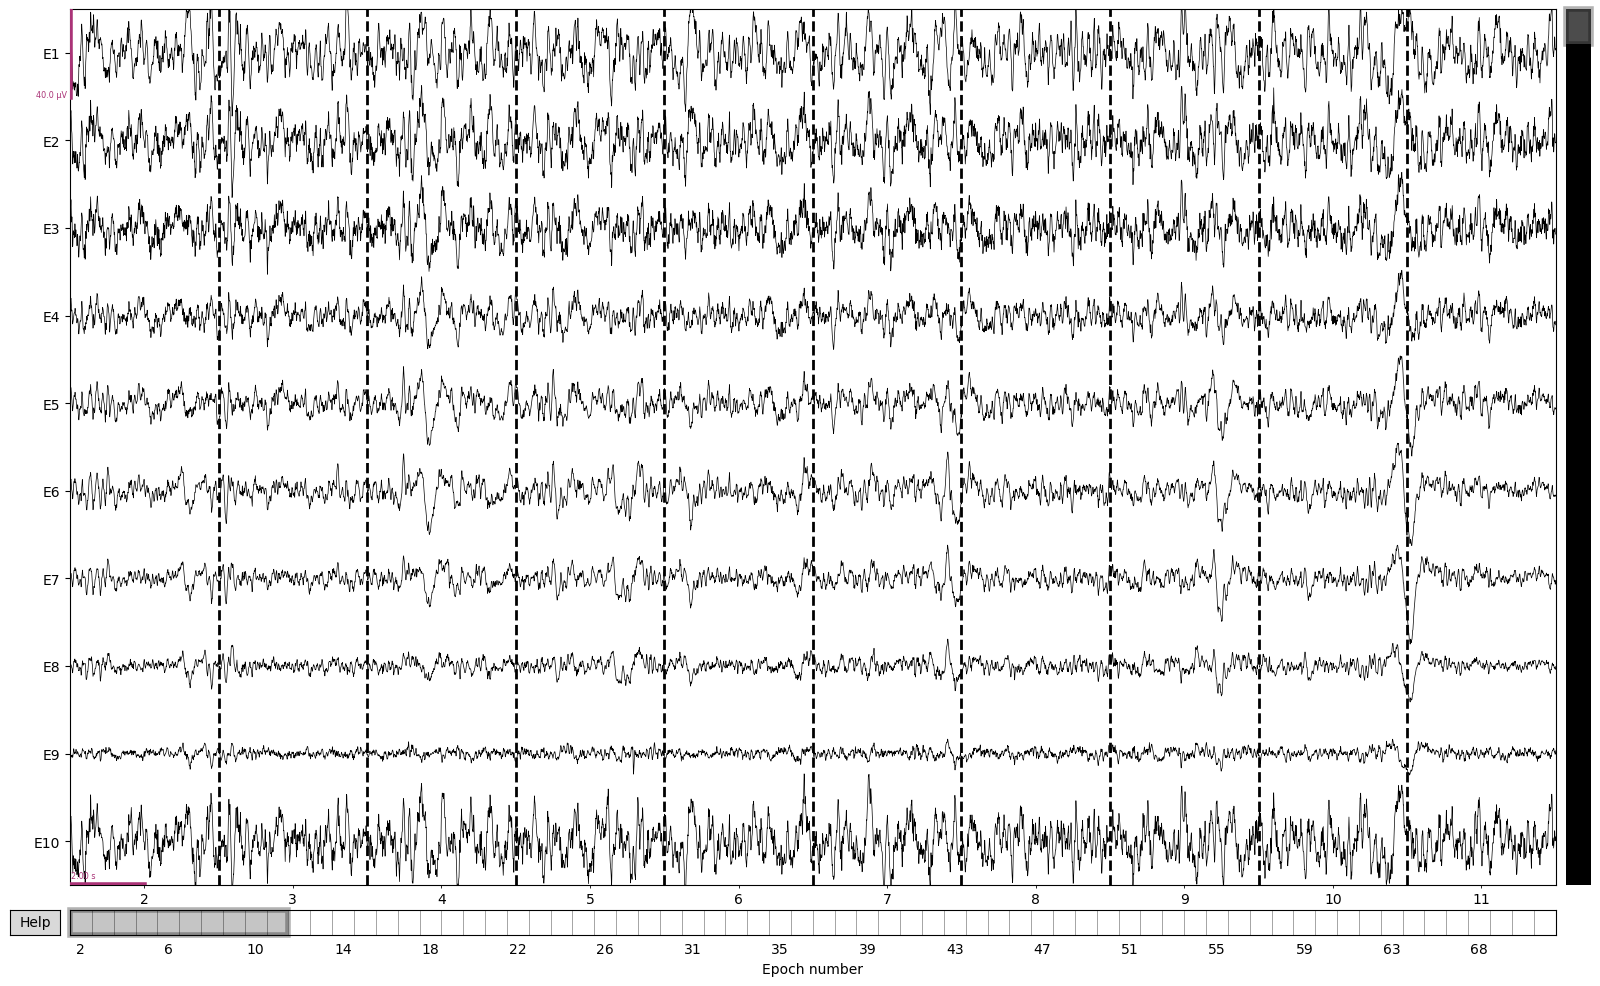

In [11]:
epochs_raw = epochs_ar.plot(n_epochs=10, n_channels=10, scalings=dict(eeg=20e-6))

Estimating rejection dictionary for eeg
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.5s
[Parallel(n_job

Fitting ICA to data using 253 channels (please be patient, this may take a while)
Selecting by explained variance: 40 components
Fitting ICA took 15.9s.
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s
[Parallel(n_job

Fitting ICA to data using 253 channels (please be patient, this may take a while)
Selecting by explained variance: 39 components
Fitting ICA took 15.0s.


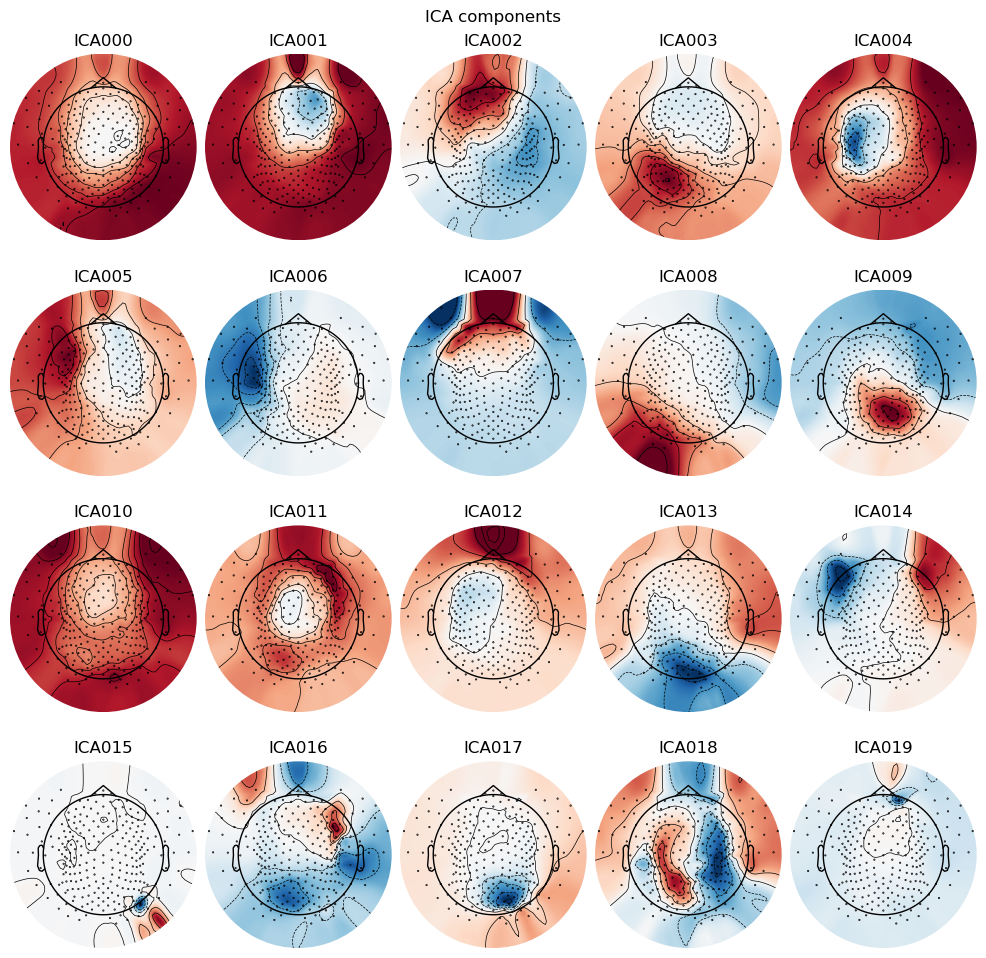

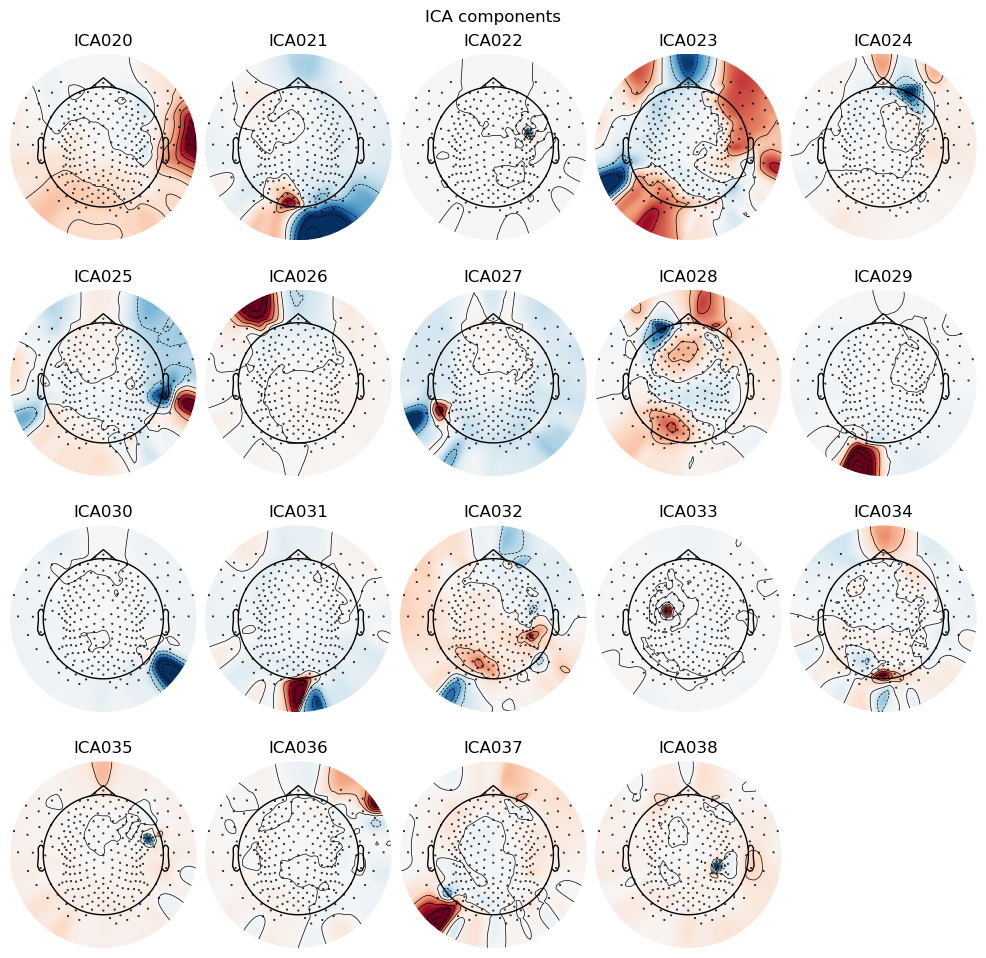

In [12]:
from mne.preprocessing import ICA

reject = autoreject.get_rejection_threshold(epochs, ch_types="eeg", random_state = 99)
ica = ICA(n_components=0.99, random_state=99,method='picard', fit_params=dict(ortho=False, extended=True))
# fit ICA on the data without really bad epochs
ica.fit(epochs[~reject_log.bad_epochs].copy().filter(l_freq=2, h_freq=None))
ica.fit(epochs.copy().filter(l_freq=2, h_freq=None))

ica_plot = ica.plot_components()

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


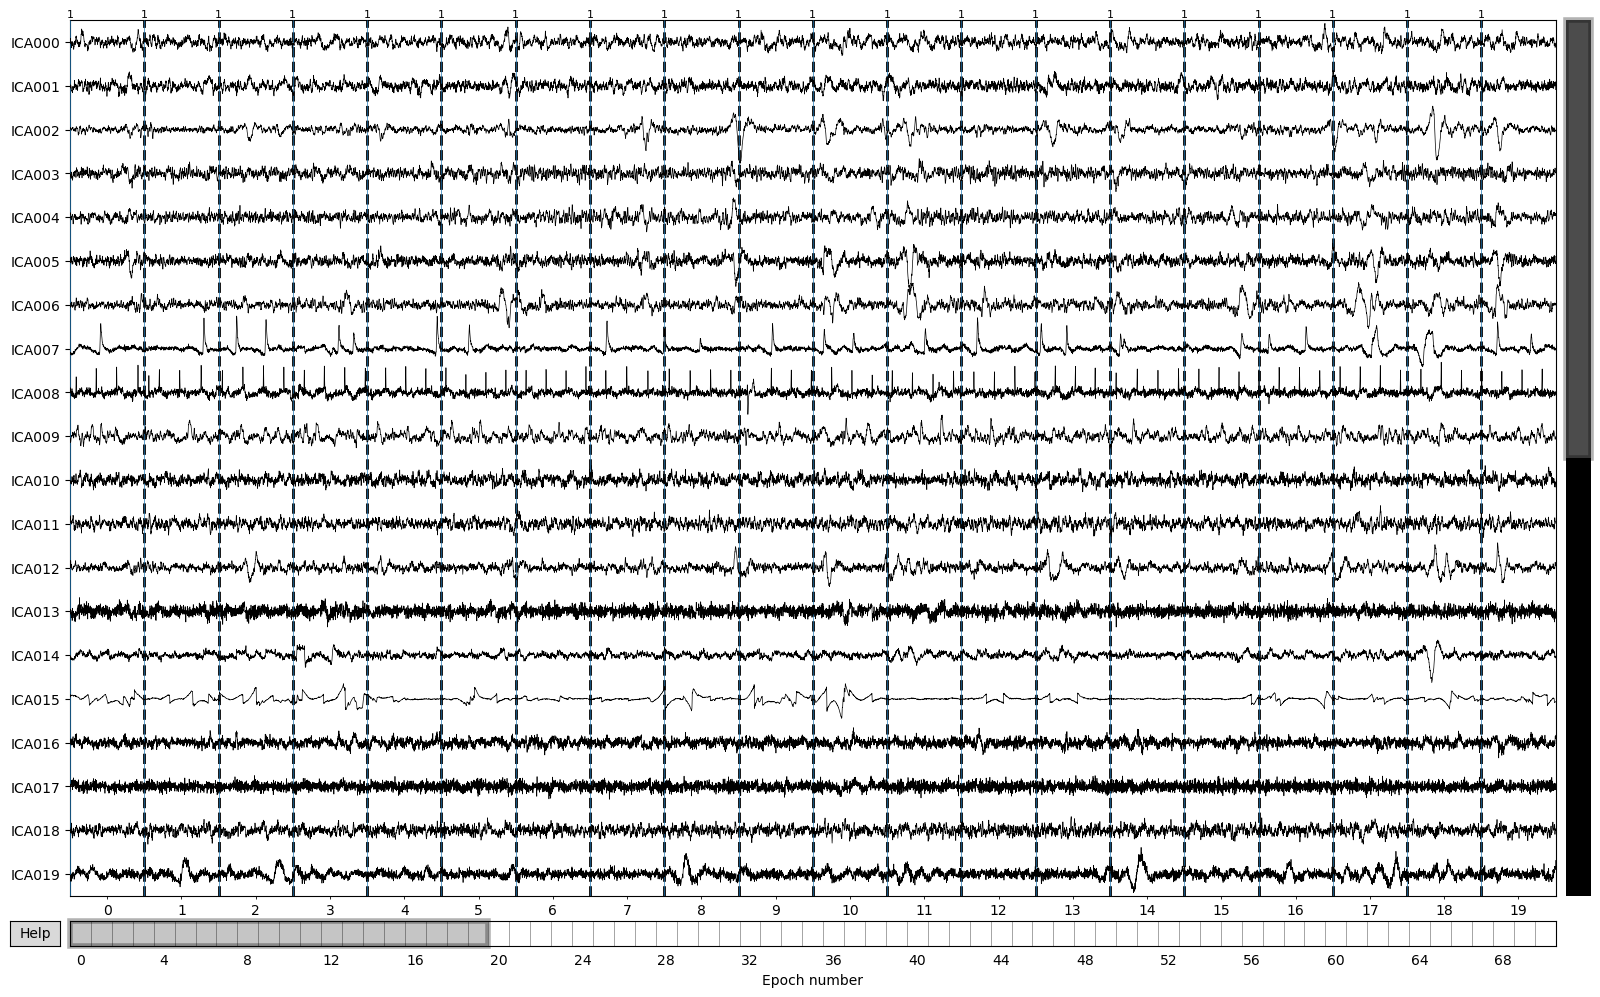

In [13]:
#ica_plot = ica.plot_sources(
#    epochs[~reject_log.bad_epochs])
ica_plot = ica.plot_sources(
    epochs)

/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_23388/1342085171.py:4: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs_ar, ica, method="iclabel")
/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_23388/1342085171.py:4: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs_ar, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
{'y_pred_proba': array([0.57370955, 0.6849894 , 0.9073935 , 0.9866967 , 0.99732316,
       0.4866866 , 0.97258365, 0.68838584, 0.80467075, 0.98804694,
       0.6422399 , 0.57006115, 0.83855736, 0.8625632 , 0.8889403 ,
       0.6725222 , 0.8051534 , 0.6401429 , 0.72906655, 0.37058833,
       0.39881498, 0.59159666, 0.9974097 , 0.7976101 , 0.89491755,
       0.84425706, 0.8378309 , 0.5944971 , 0.9380486 , 0.5547333 ,
       0.88828737, 0.6415918 , 0.7942039 , 0.9977174 , 0.44587296,
       0.97481424, 0.36823782, 0.63232803, 0.4475822 ], dtype=float32), 'labels': ['other', 'brain', 'brain', 'brain', 'brain', 'other', 'brain', 'eye blink', 'heart beat', 'brain', 'other', 'other', 'eye blink', 'brain', 'eye blink', 'other', 'other', 'brain', 'brain', 'other', 'muscle artifact', 'other', 'channel noise', 'other', 'muscle artifact', 'other', 'eye blink', 'other', 'other', 'other', 'channel noise', 'muscle artifac

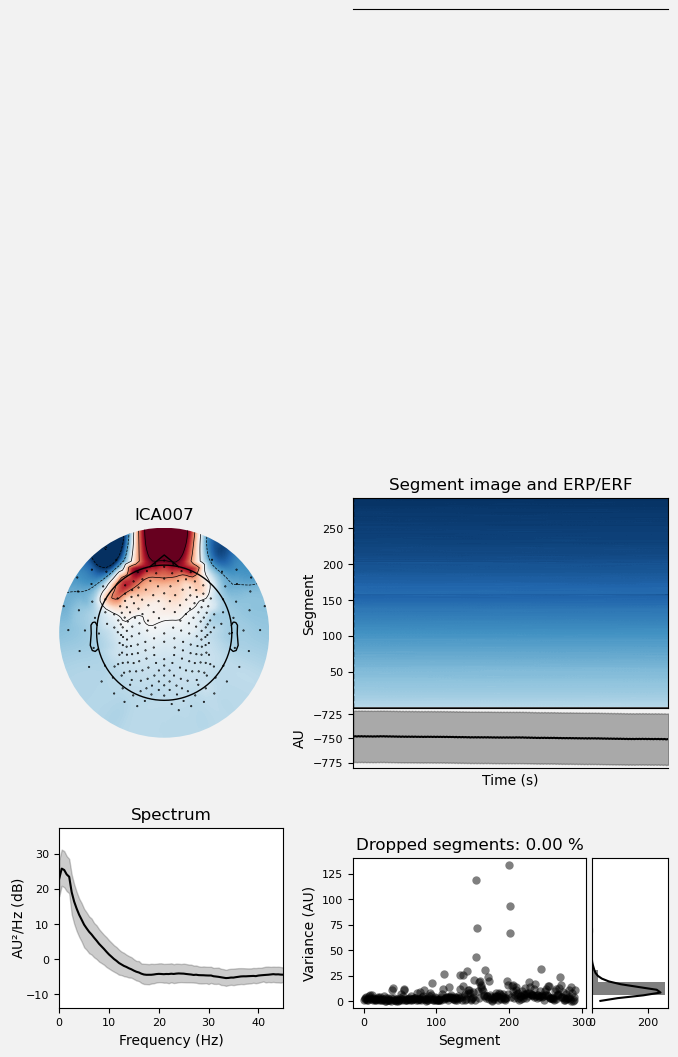

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


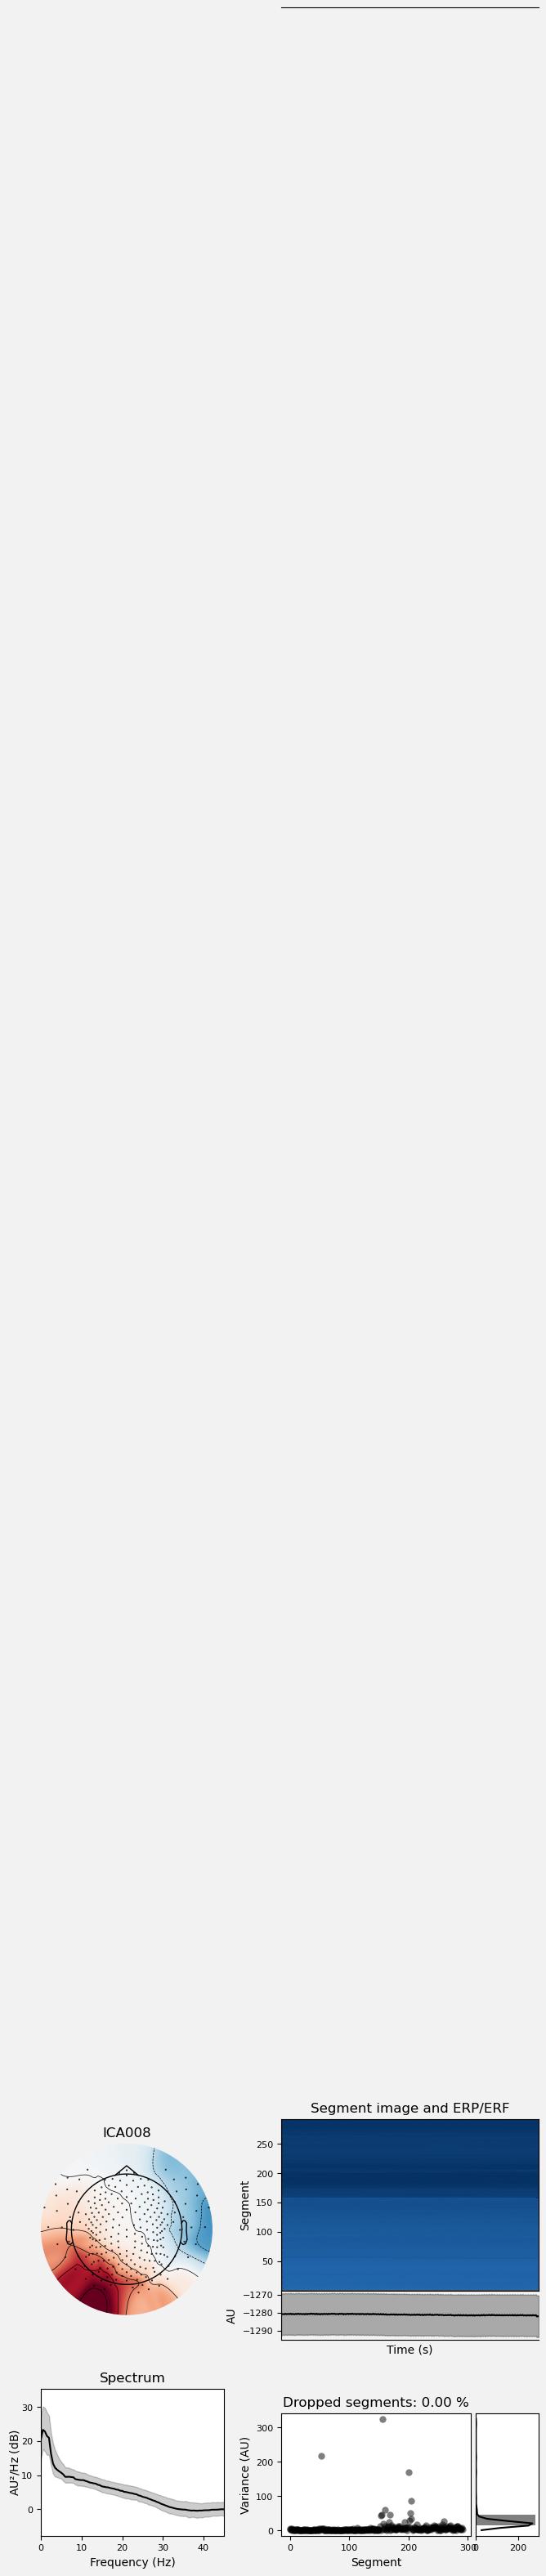

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


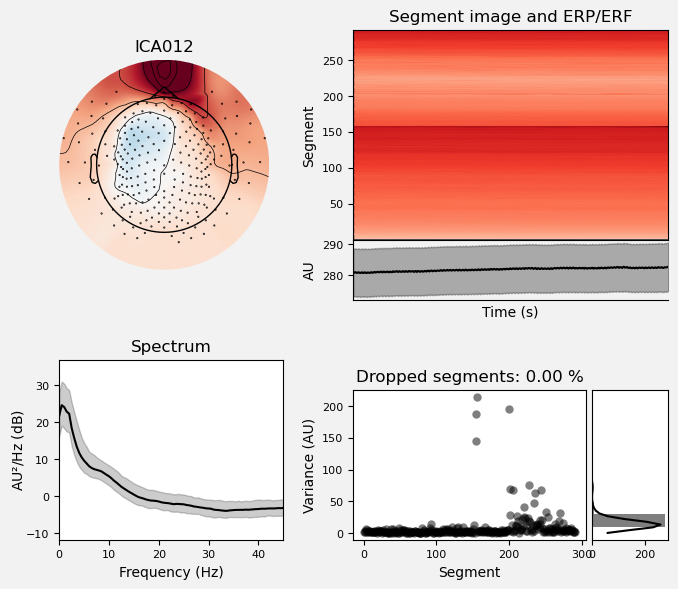

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


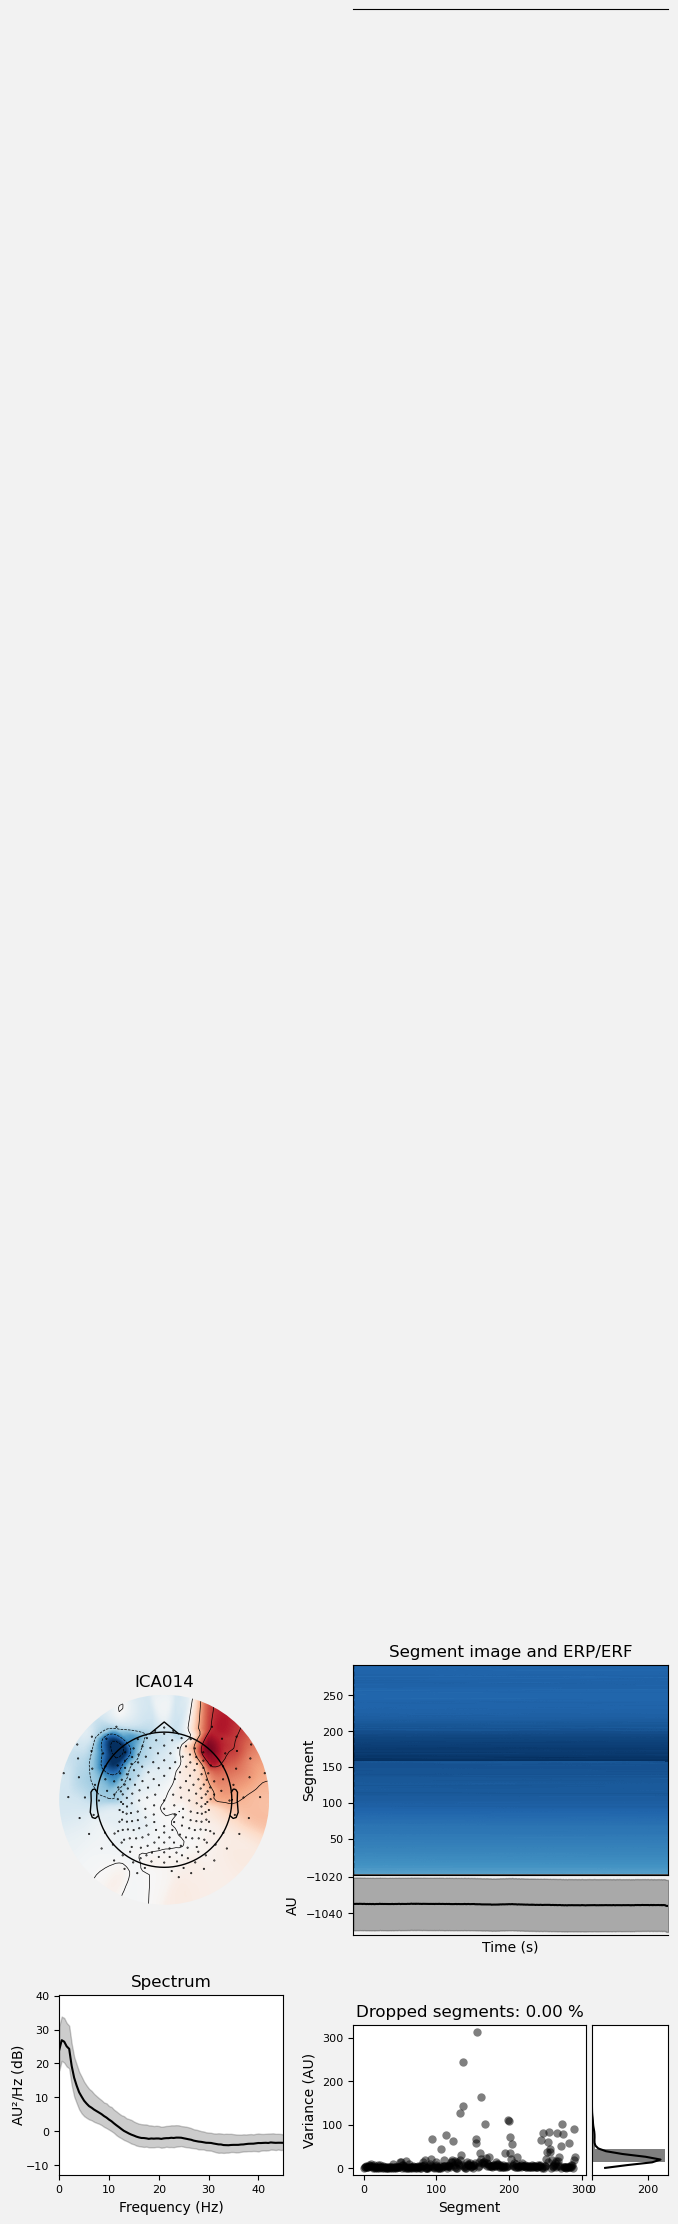

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


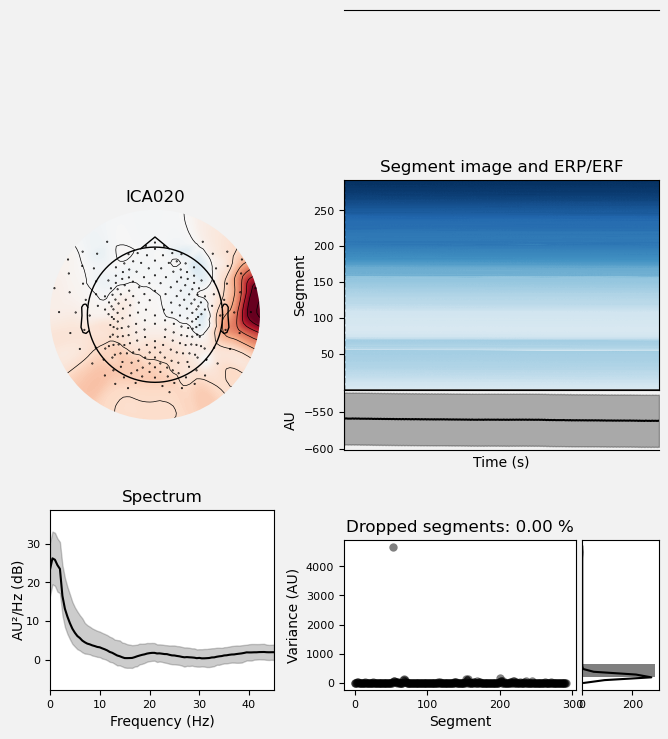

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


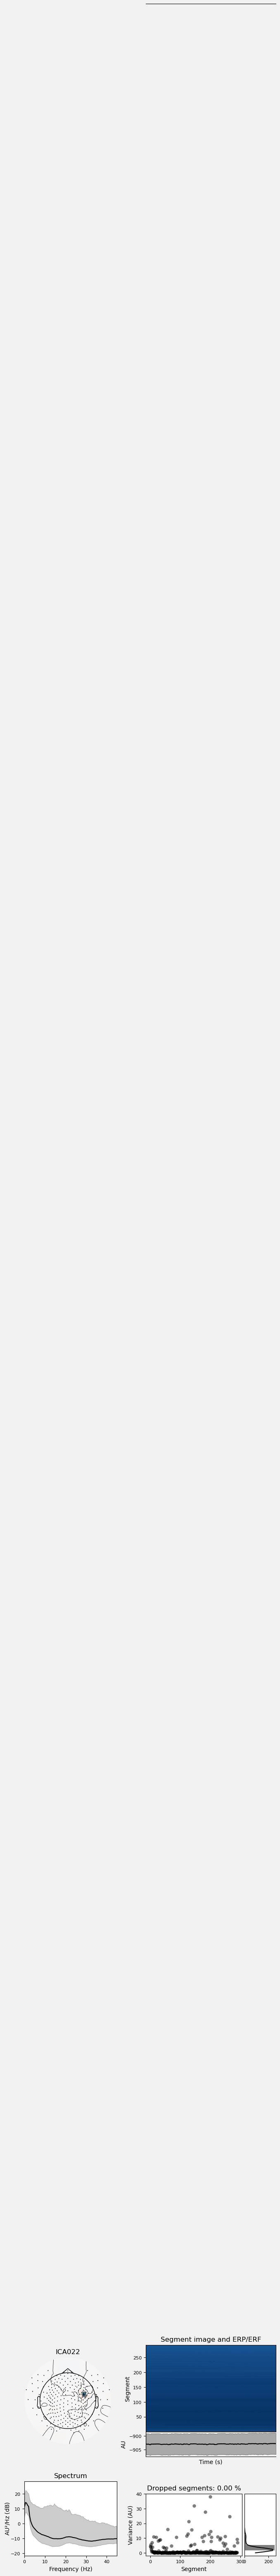

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


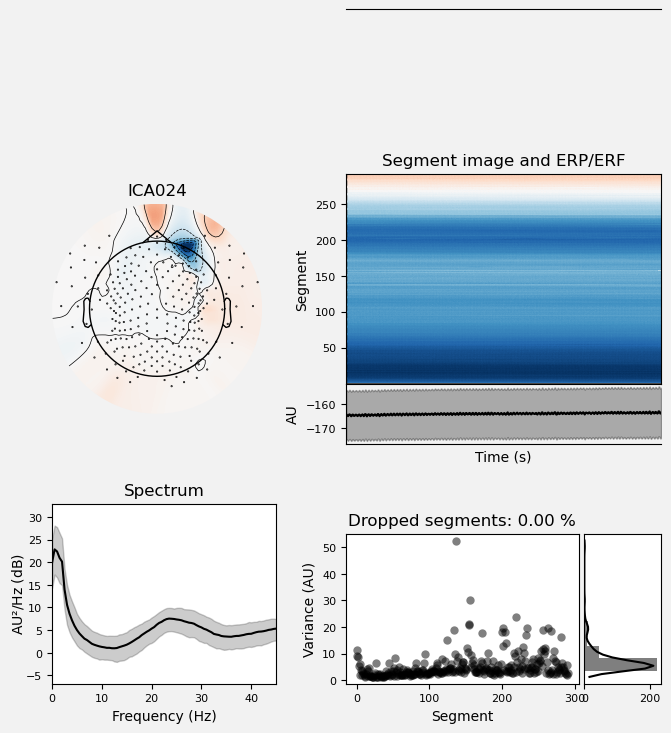

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


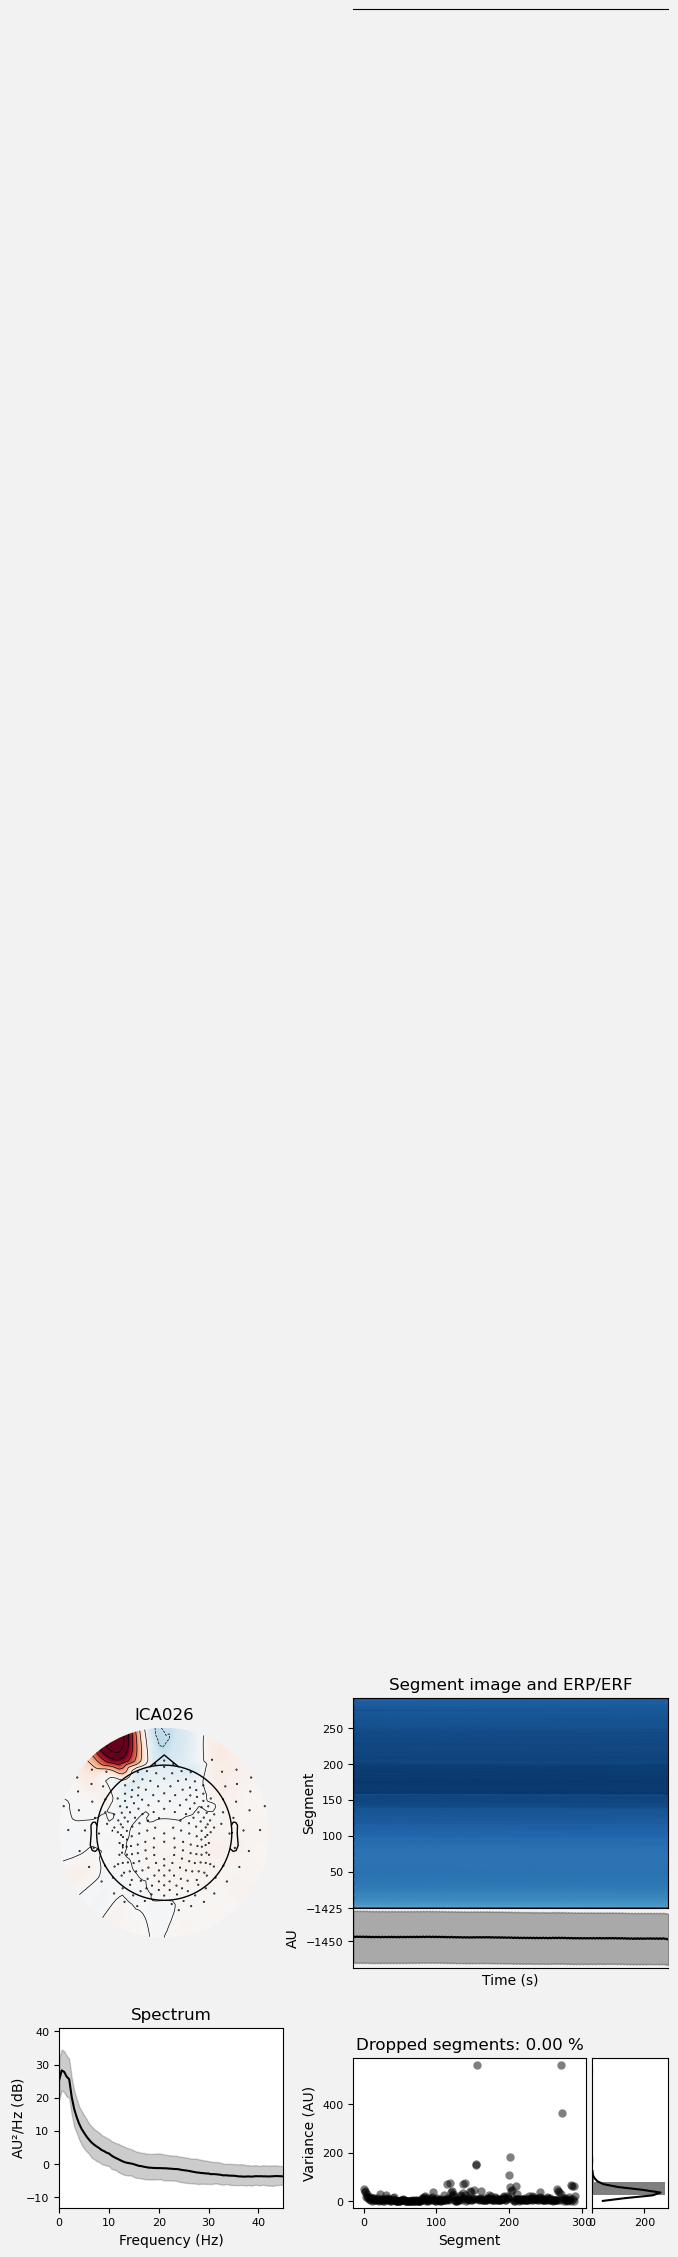

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


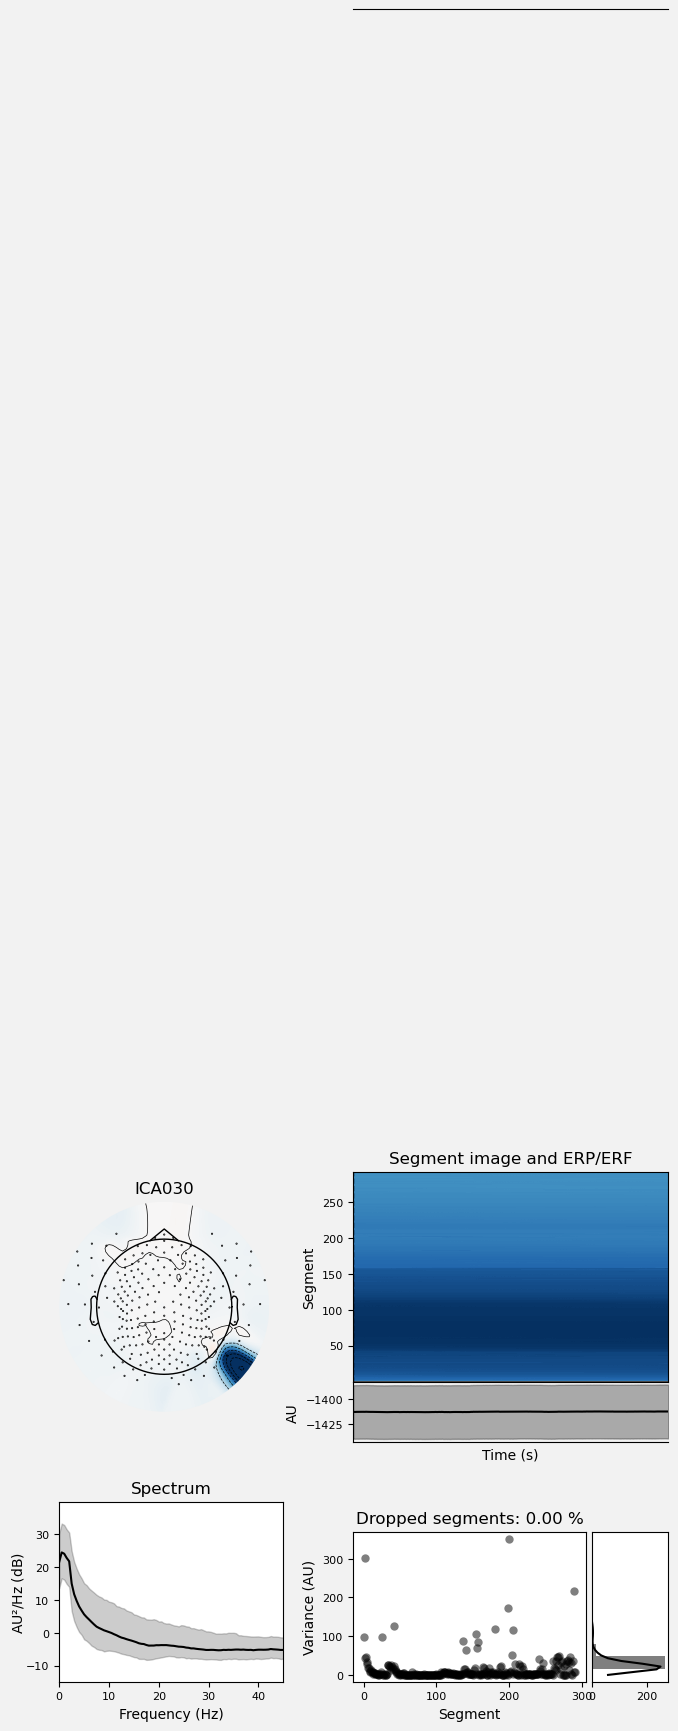

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


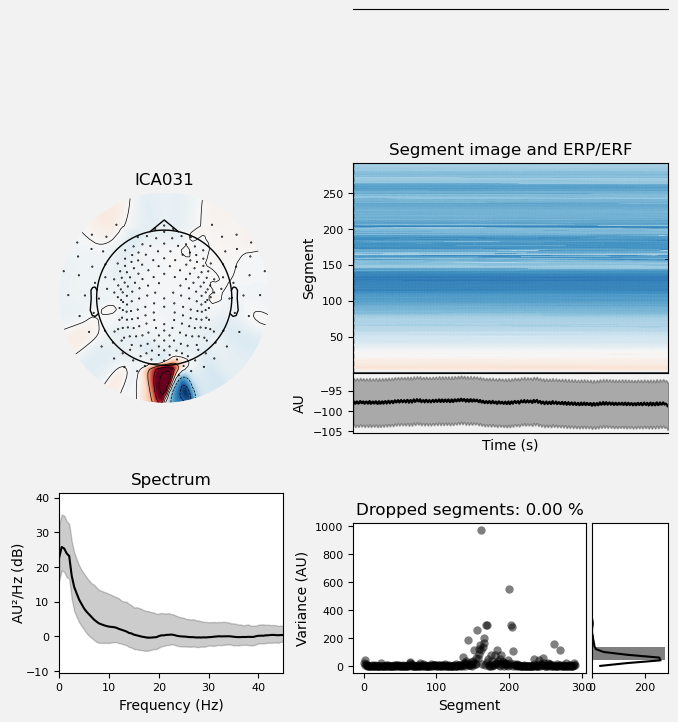

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


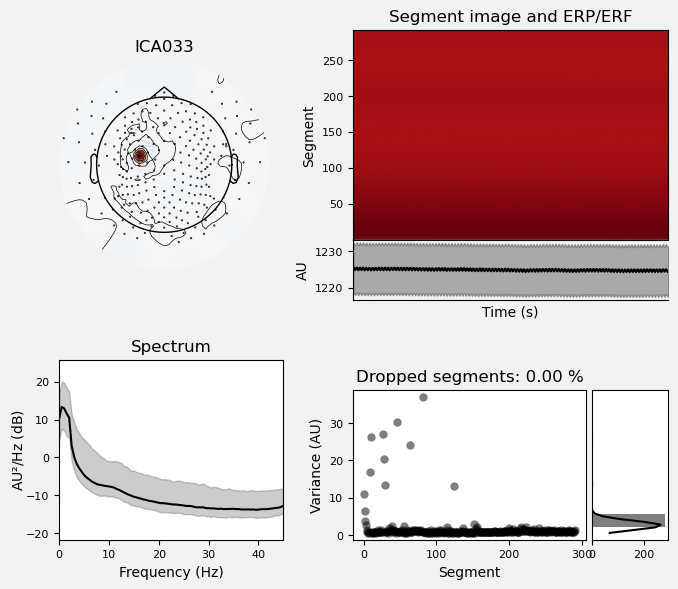

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


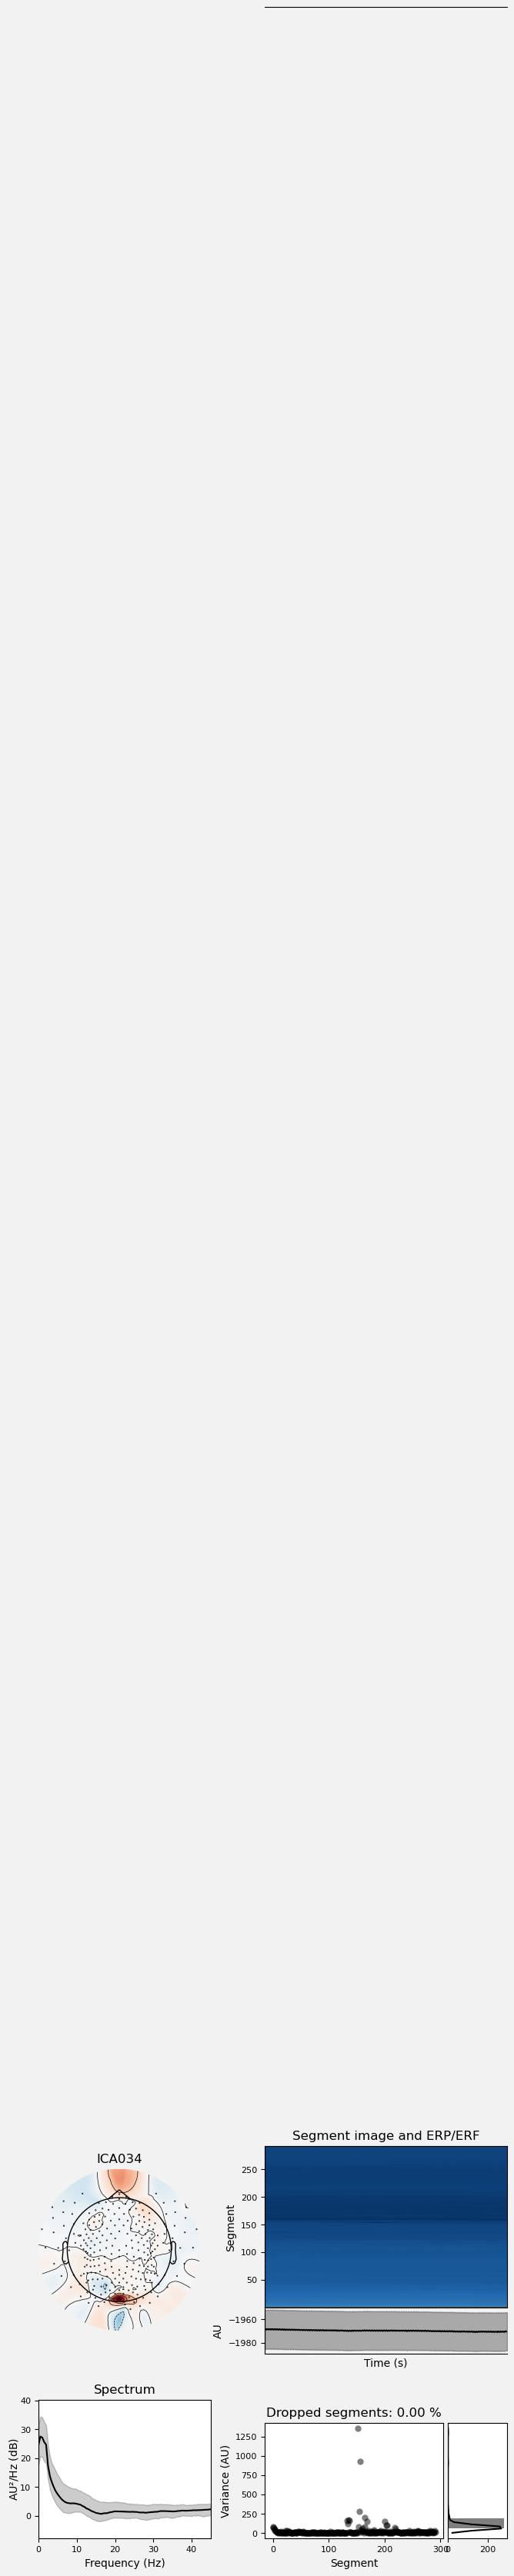

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


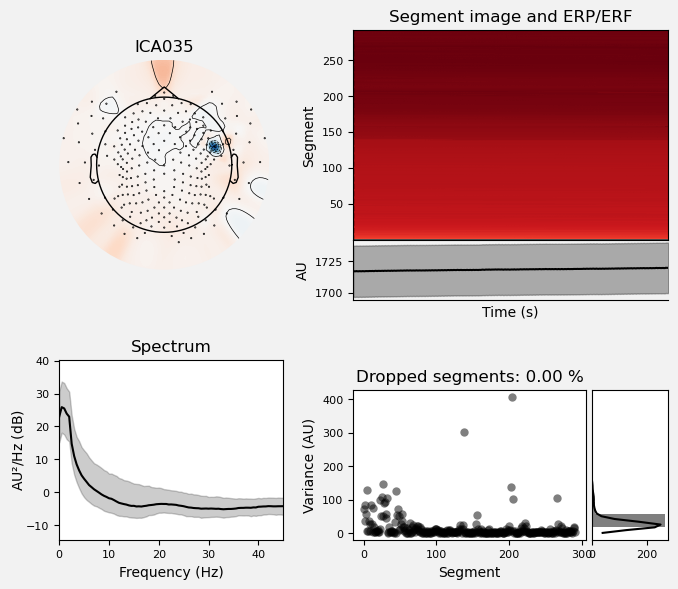

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


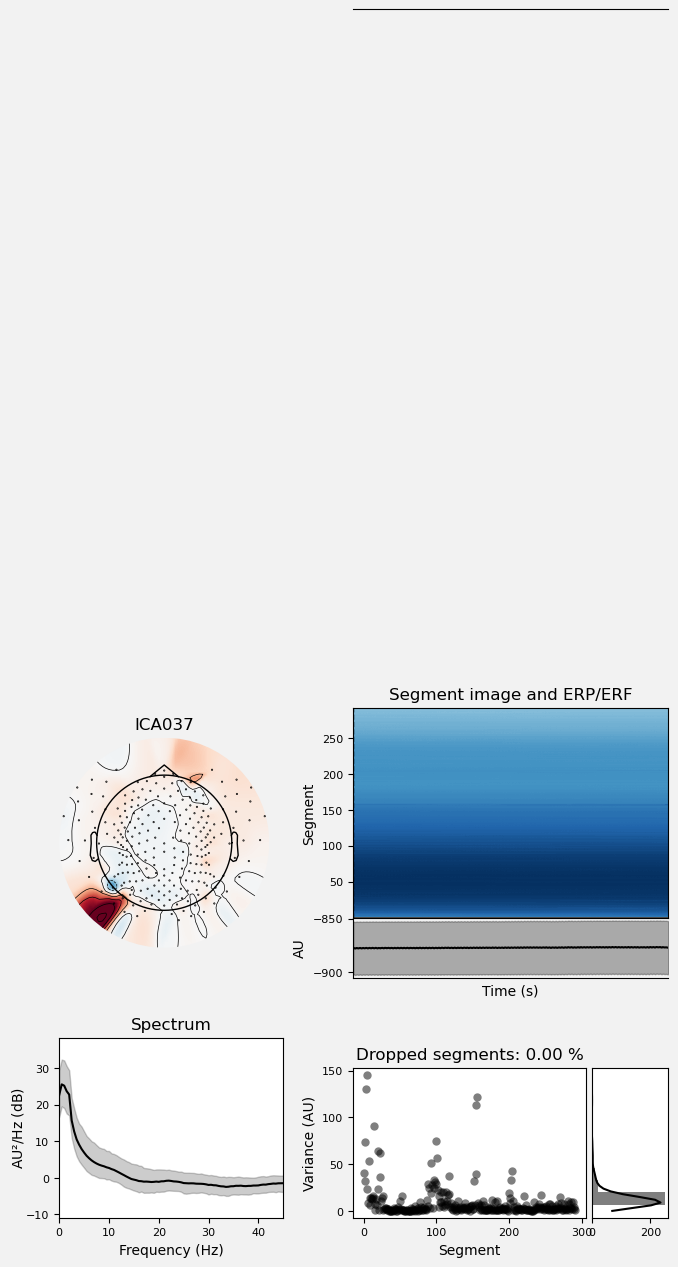

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated


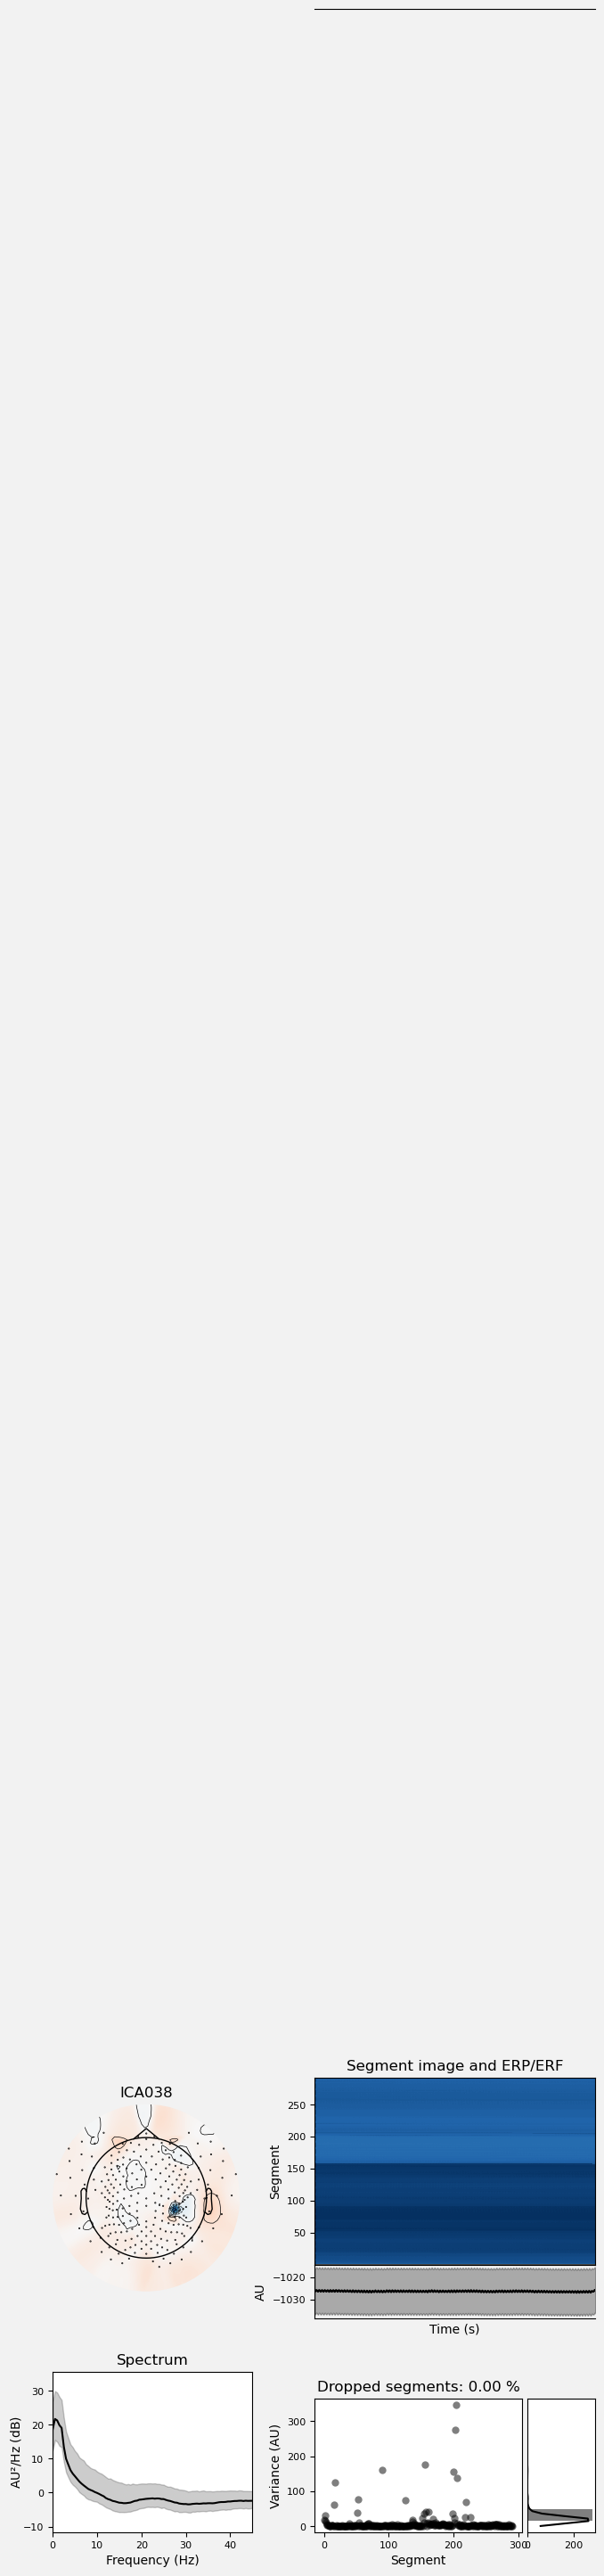

In [14]:
from mne_icalabel import label_components
# https://labeling.ucsd.edu/tutorial/overview more on IC labeling

ic_labels = label_components(epochs_ar, ica, method="iclabel")
labels = ic_labels["labels"]
exclude = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
print(ic_labels)
print(exclude)
for idx in exclude:
    #ica.exclude.append(idx)
    ica.plot_properties(raw, picks=[idx], psd_args={"fmax": 45.0})

In [15]:
ica.exclude = exclude #[2,  6, 8, 11, 12, 19, 20,25,26]
epochs_clean = ica.apply(epochs, exclude=ica.exclude)
ar = autoreject.AutoReject(
    n_interpolate=[1, 2, 4, 8, 16, 32, 64, 128], random_state=11, n_jobs=1, verbose=True
)
ar.fit(epochs_clean[:30])  # fit on a few epochs to save time
epochs_clean_ar, reject_clean_log = ar.transform(epochs, return_log=True)


epochs_clean_ar.save(f'{clean_epochs_path}/sub-{subject}-cleaned-epo.fif', overwrite=True)

Applying ICA to Epochs instance
    Transforming to ICA space (39 components)
    Zeroing out 15 ICA components
    Projecting back using 253 PCA components
Running autoreject on ch_type=eeg


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/autoreject/utils.py:73: UserWarning: 4 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Creating augmented epochs : 0/253 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/253 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/8 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=64


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/autoreject/utils.py:73: UserWarning: 4 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Repairing epochs : 0/71 [00:00<?,       ?it/s]

Dropped 1 epoch: 70


No projector specified for this dataset. Please consider the method self.add_proj.


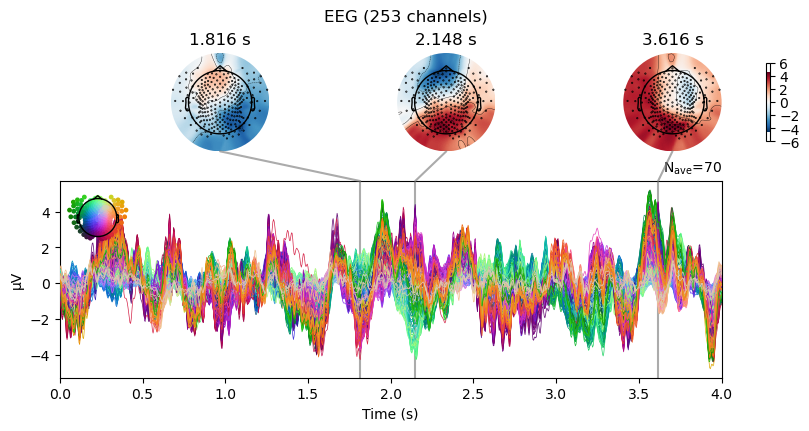

Effective window size : 4.004 (s)
Averaging across epochs...


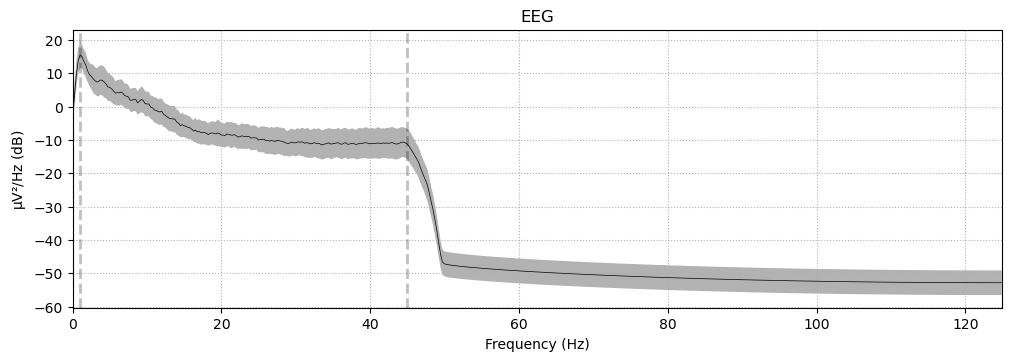

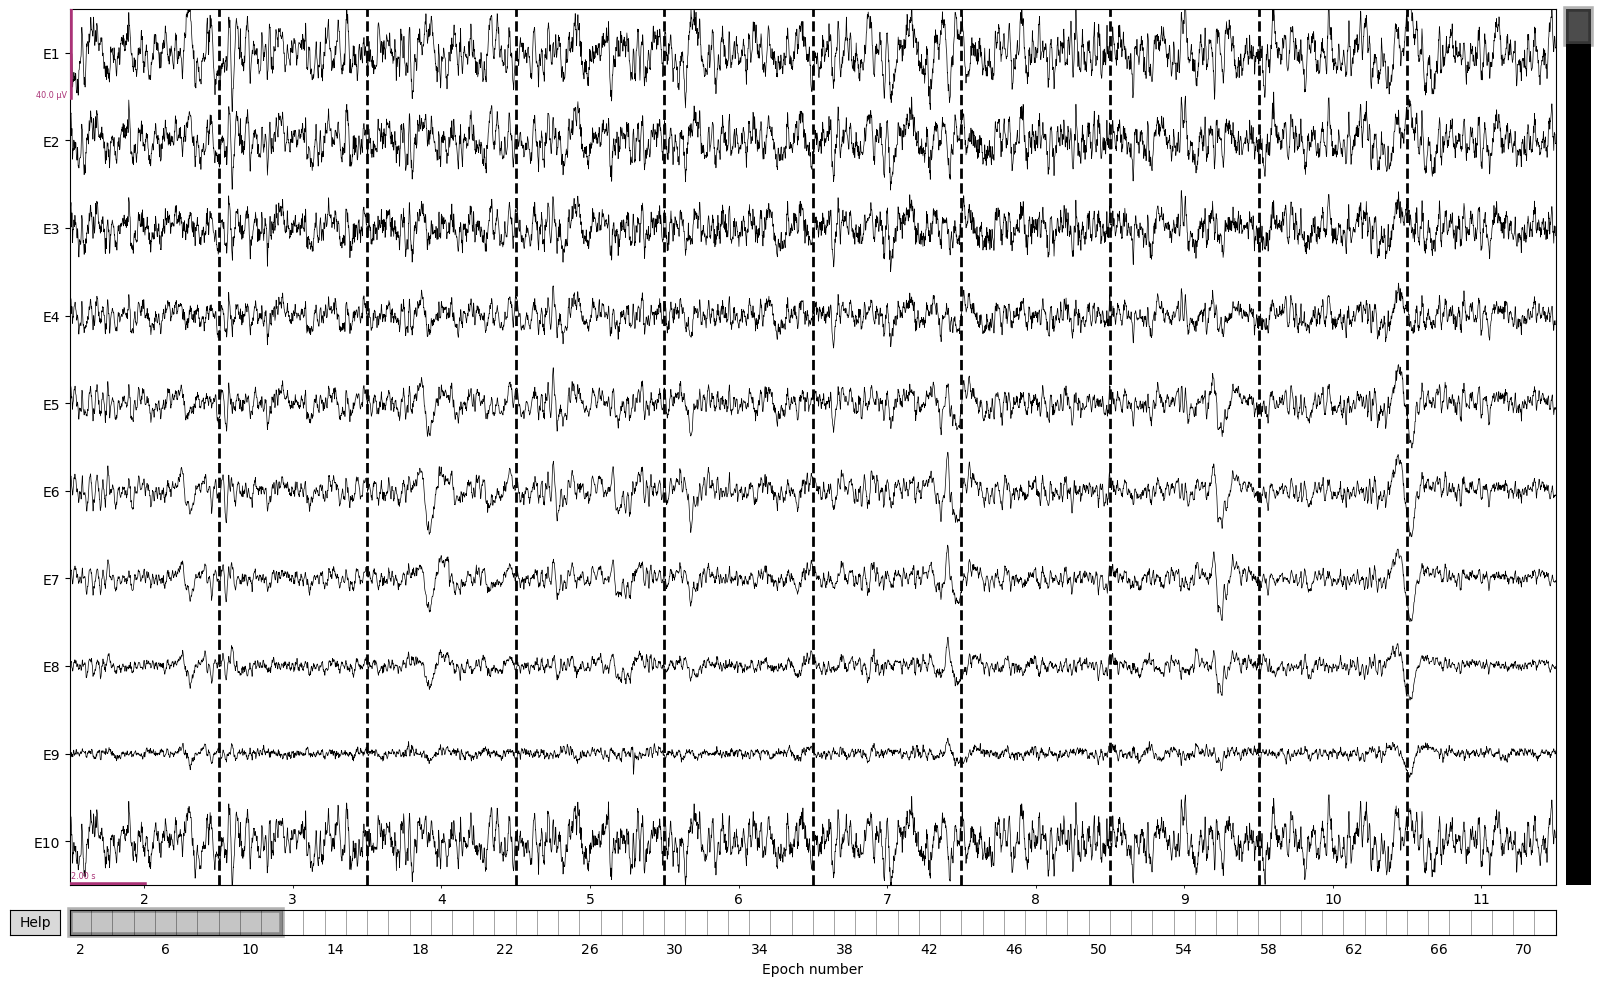

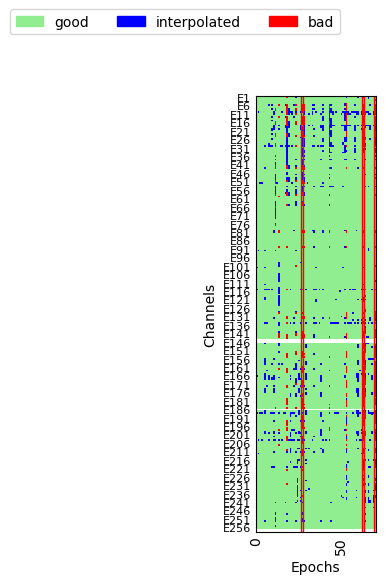

In [16]:
epoch_ar_plot = epochs_clean_ar.copy().average().detrend().plot_joint()
epochs_ar_psd = epochs_clean_ar.compute_psd(
    method="welch", picks="eeg", exclude="bads"
).plot(average=True, picks="eeg", exclude="bads", show=False)
epochs_clean_plot = epochs_clean_ar.plot(n_epochs=10, n_channels=10, scalings=dict(eeg=20e-6))
reject_plot = reject_log.plot(orientation="horizontal")

In [17]:


def specparam2pandas(fg):
    """
    Converts a FOOOFGroup object into a pandas DataFrame, with peak parameters and
    corresponding aperiodic fit information.

    Args:
    -----
    fg : specpramGroup
        The FOOOFGroup object containing the fitting results.

    Returns:
    --------
    peaks_df : pandas.DataFrame
        A DataFrame with the peak parameters and corresponding aperiodic fit information.
        The columns are:
        - 'CF': center frequency of each peak
        - 'PW': power of each peak
        - 'BW': bandwidth of each peak
        - 'error': fitting error of the aperiodic component
        - 'r_squared': R-squared value of the aperiodic fit
        - 'exponent': exponent of the aperiodic component
        - 'offset': offset of the aperiodic component
        - 'knee': knee parameter of the aperiodic component [if is initially present in the fg object]
    Notes:
    ------
    This function creates two DataFrames. The first DataFrame `fooof_aperiodic`
    contains the aperiodic fit information and is based on the `aperiodic_params`
    attribute of the FOOOFGroup object. The columns are inferred using the
    `get_ap_indices()` and `infer_ap_func()` functions from the FOOOF package.
    The second DataFrame `peak_df` contains the peak parameters and is based on the
    `peak_params` attribute of the FOOOFGroup object. The column names are renamed
    to match the headers of `fooof_aperiodic`, and the 'ID' column is cast to integer.
    The two DataFrames are then merged based on a shared 'ID' column.
    """

    fooof_aperiodic = (
        pd.DataFrame(
            fg.get_params("aperiodic_params"),
            columns=get_ap_indices(
                infer_ap_func(np.transpose(fg.get_params("aperiodic_params")))
            ),
        )
        .assign(error=fg.get_params("error"), r_squared=fg.get_params("r_squared"))
        .reset_index(names=["ID"])
    )
    return (
        pd.DataFrame(fg.get_params("peak_params"))  # prepare peaks dataframe
        .set_axis(["CF", "PW", "BW", "ID"], axis=1)  # rename cols
        .astype({"ID": int})
        .join(fooof_aperiodic.set_index("ID"), on="ID")
    )


    Using multitaper spectrum estimation with 7 DPSS windows


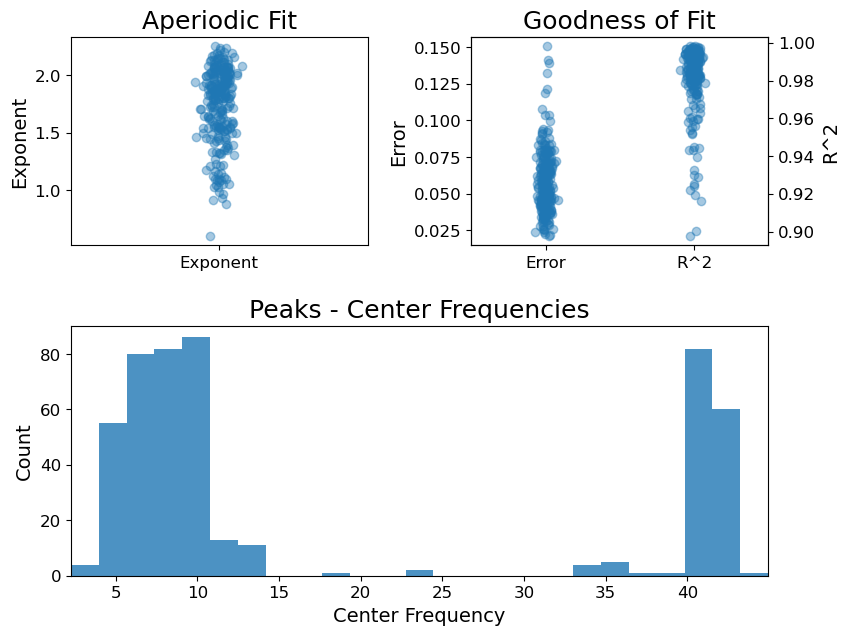

In [18]:
psd = epochs_clean_ar.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra
fg = SpectralGroupModel(peak_width_limits=[1, 6], min_peak_height=0.15,
                peak_threshold=2., max_n_peaks=6, verbose=False)

# Define the frequency range to fit
freq_range = [2, 45]
fg.fit(freqs, spectra, freq_range)
fg.plot()

In [19]:
import pandas as pd
from specparam.core.funcs import infer_ap_func
from specparam.core.info import get_ap_indices
df = specparam2pandas(fg)
df.to_csv(f'{specparam_path}/sub-{subject}-specparam.csv', index=False)